## Fully automated IRAC photometry

Requirements:

    stsci.convolve
    tqdm

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from grizli import utils

import golfir.model

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


Products in https://s3.amazonaws.com/grizli-v1/Pipeline/j213512m0103/IRAC/j213512m0103.irac.html.

In [248]:
root = 'j213512m0103'

In [3]:
# Workspace
PATH = os.path.join(os.getenv('HOME'), 'Research/HST/CHArGE/IRAC/')
os.chdir(PATH)

if not os.path.exists(root):
    os.mkdir(root)

os.chdir(root)
print('Working directory: ', os.getcwd())

Working directory:  /Users/gbrammer/Research/HST/CHArGE/IRAC/j213512m0103


In [19]:
# Fetch data from AWS
if not os.path.exists(f'{root}-ch1_drz_sci.fits'):
    # Need *-ch*fits *log.fits *psf*fits from 
    #.    https://s3.amazonaws.com/grizli-v1/Pipeline/{root}/IRAC/
    #
    # And *-seg*fits* *phot*fits* *-ir* *-f1*fits* from
    #     https://s3.amazonaws.com/grizli-v1/Pipeline/{root}/Prep/
    golfir.model.ImageModeler.fetch_from_aws(root)

In [249]:
# Local ds9 for interactive display 
try:
    import grizli.ds9
    ds9 = grizli.ds9.DS9()
except:
    ds9 = None
    pass

In [250]:
# Show images in DS9, optional
if ds9:
    from grizli.pipeline import auto_script
    PWD = os.getcwd()

    ds9.frame(1)
    ds9.set(f'file {PWD}/{root}-ir_drz_sci.fits')
    ds9.set_defaults(match='wcs')
    ds9.frame(2)
    ds9.set(f'file {PWD}/{root}-ir_seg.fits')
    ds9.frame(3)
    ds9.set(f'file {PWD}/{root}-ch1_drz_sci.fits')
    ds9.frame(4)
    ds9.set(f'file {PWD}/{root}-ch2_drz_sci.fits')

    ds9.set('frame lock wcs')
    ds9.set('lock colorbar')

    auto_script.field_rgb(root, HOME_PATH=None, ds9=ds9, scale_ab=23)
    ds9.set('rgb lock colorbar')
    ds9.set('frame lock wcs')

PATH: ./, files:['./j213512m0103-f606w_drc_sci.fits', './j213512m0103-f110w_drz_sci.fits', './j213512m0103-f814w_drc_sci.fits', './j213512m0103-f140w_drz_sci.fits']
Use preferred r/g/b combination: ['f140w', 'f110w', 'f814w']
# field_rgb j213512m0103: r f140w / g f110w / b f814w


In [255]:
# Modeling arguments
kwargs = {'ds9': ds9, 
          'patch_arcmin': 1.0,      # Size of patch to fit
          'patch_overlap': 0.2,     # Overlap of automatic patches
          'mag_limit': [24, 27],    # Two-pass modeling.  Fit sources brighter than mag_limit in HST catalog
          'run_alignment': True,    # Run fine alignment between IRAC-HST, in between two steps of `mag_limit`
          'galfit_flux_limit': np.inf,  # Brightness limit (uJy) of objects to fit with GALFIT
          'refine_brightest': True, # Refine masked bright objects with galfit
          'any_limit': 15,          # Brightness limit below which to mask *any* sources
          'point_limit': 15,        # Brightness limit below which to mask point-like sources
          'bright_sn': 30,          # S/N threshold for masked pixels of bright object
          'bkg_kwargs': {'order_npix': 64},          # Arguments to the local background routine
          'channels': ['ch1', 'ch2'],  # Channels to try
          'psf_only': False,        
          'use_saved_components': False, # Use models from a "components" file if found
          'window': None            # PSF-match windowing
          }

In [25]:
# z~9 candidate MACSJ2135−0763 from Repp et al. (2016)
# https://ui.adsabs.harvard.edu/abs/2016MNRAS.457.1399R/abstract
ra, dec = 323.7844415, -1.044944766

# Recenter nearby
ra, dec = 323.7882262, -1.050061227

# Fit 0.6' square patch around the target of interest
kwargs['patch_arcmin'] = 0.6

In [162]:
# Run the models
models = {}

for ch in ['ch1', 'ch2']:
    try:
        modeler = golfir.model.ImageModeler(root=root, lores_filter=ch, **kwargs) 
    except:
        continue
    
    print('####################\n\nRun {0} \n\n####################'.format(ch))        
    modeler.run_full_patch(rd_patch=(ra, dec), **kwargs)
    models[ch] = modeler

# (Sat Mar  7 17:14:24 2020)
Use HST reference image "j213512m0103-f140w_drz_sci.fits".
# (Sat Mar  7 17:14:24 2020)
Watershed segmentation dilation, smooth_size=5
# (Sat Mar  7 17:14:33 2020)
Read lores data: j213512m0103-ch1

# (Sat Mar  7 17:14:33 2020)
Read avg psf: /Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/golfir/data/psf/irsa_0.1pix_ch1_psf.fits

Read PSF data r20813056-ch1.log.fits / r20813056-ch1-0.1.psf.fits
Use rotated `avg_psf`.
get_exposure_time r20813056 (0/1)
# (Sat Mar  7 17:14:34 2020)
Read component file "j213512m0103-ch1_components.fits".
####################

Run ch1 

####################
# (Sat Mar  7 17:14:34 2020)
Get 0.6' patch around (323.78823, -1.05006)



0it [00:00, ?it/s]

# (Sat Mar  7 17:14:34 2020)
Use transform [1.769331080574974, -1.746192785579638, 0.009822505700967916, 1.000746267302724] from j213512m0103-ch1_model.fits
# (Sat Mar  7 17:14:34 2020)
Compute 154 models for patch (mag_auto < 24.0)


154it [00:01, 127.17it/s]


# (Sat Mar  7 17:14:35 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sat Mar  7 17:14:35 2020)
Patch least squares
[0. 0. 0. 1.] 15988.283588236687
[0. 0. 0. 1.] 15988.283588236687
[0.1 0.  0.  1. ] 16086.76222297497
[-0.1618034  0.         0.         1.       ] 16391.783236597294
[0. 0. 0. 1.] 15988.283588236687
[-0.0618034  0.         0.         1.       ] 16057.811895343173
[0.0381966 0.        0.        1.       ] 15994.004991717185
[0.01322324 0.         0.         1.        ] 15986.010604633153
[0.01335547 0.         0.         1.        ] 15986.010307984294
[0.01348902 0.         0.         1.        ] 15986.010462705068
[0.01335547 0.         0.         1.        ] 15986.010307984294
[0.01335547 0.1        0.         1.        ] 16277.132002035874
[ 0.01335547 -0.1618034   0.          1.        ] 16170.81423771201
[0.01335547 0.         0.         1.        ] 15986.010307984294
[ 0.01335547 -

1it [00:00,  8.05it/s]

# (Sat Mar  7 17:14:36 2020)
Compute 240 models for patch (mag_auto < 27.0)


240it [00:01, 155.99it/s]


# (Sat Mar  7 17:14:38 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sat Mar  7 17:14:38 2020)
Patch least squares
# (Sat Mar  7 17:14:38 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sat Mar  7 17:14:38 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': [], 'bright_sn': 30}
# (Sat Mar  7 17:14:38 2020)
Patch least squares


173it [00:01, 112.81it/s]


# (Sat Mar  7 17:14:41 2020)
Use HST reference image "j213512m0103-f140w_drz_sci.fits".
# (Sat Mar  7 17:14:42 2020)
Watershed segmentation dilation, smooth_size=5


0it [00:00, ?it/s]

# (Sat Mar  7 17:14:51 2020)
Read lores data: j213512m0103-ch2

# (Sat Mar  7 17:14:51 2020)
Read avg psf: /Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/golfir/data/psf/irsa_0.1pix_ch2_psf.fits

Read PSF data r20813056-ch2.log.fits / r20813056-ch2-0.1.psf.fits
Use rotated `avg_psf`.
get_exposure_time r20813056 (0/1)
# (Sat Mar  7 17:14:51 2020)
Read component file "j213512m0103-ch2_components.fits".
####################

Run ch2 

####################
# (Sat Mar  7 17:14:51 2020)
Get 0.6' patch around (323.78823, -1.05006)

# (Sat Mar  7 17:14:51 2020)
Use transform [2.030548713366671, -1.444392343403487, 0.003673869456204724, 1.001075326346425] from j213512m0103-ch2_model.fits
# (Sat Mar  7 17:14:51 2020)
Compute 154 models for patch (mag_auto < 24.0)


154it [00:01, 123.26it/s]


# (Sat Mar  7 17:14:52 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sat Mar  7 17:14:52 2020)
Patch least squares
[0. 0. 0. 1.] 11746.178486028277
[0. 0. 0. 1.] 11746.178486028277
[0.1 0.  0.  1. ] 11798.398105498622
[-0.1618034  0.         0.         1.       ] 11935.168836234108
[0. 0. 0. 1.] 11746.178486028277
[-0.0618034  0.         0.         1.       ] 11777.489787209546
[0.0381966 0.        0.        1.       ] 11751.014884074179
[0.00910072 0.         0.         1.        ] 11745.712480359995
[0.00873952 0.         0.         1.        ] 11745.711976606988
[0.00882691 0.         0.         1.        ] 11745.711953806844
[0.00891518 0.         0.         1.        ] 11745.712024522942
[0.00882691 0.         0.         1.        ] 11745.711953806844
[0.00882691 0.1        0.         1.        ] 11834.430237744404
[ 0.00882691 -0.1618034   0.          1.        ] 11894.836505396932
[0.00882691 

1it [00:00,  8.21it/s]

# (Sat Mar  7 17:14:53 2020)
Compute 240 models for patch (mag_auto < 27.0)


240it [00:01, 163.15it/s]


# (Sat Mar  7 17:14:55 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sat Mar  7 17:14:55 2020)
Patch least squares
# (Sat Mar  7 17:14:55 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sat Mar  7 17:14:55 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': [], 'bright_sn': 30}
# (Sat Mar  7 17:14:55 2020)
Patch least squares


169it [00:01, 100.04it/s]


## Checking results

The modeling and photometry is done.  Check the results.

In [163]:
# photoz
from grizli.pipeline import photoz
import numpy as np

self, cat, zout = photoz.eazy_photoz(root+'_irac', object_only=False, apply_prior=False, 
                                     beta_prior=True, aper_ix=1, force=True, get_external_photometry=False, 
                                     compute_residuals=False, total_flux='flux_auto')

Apply catalog corrections
Compute aperture corrections: i=0, D=0.36" aperture
Compute aperture corrections: i=1, D=0.50" aperture
Compute aperture corrections: i=2, D=0.70" aperture
Compute aperture corrections: i=3, D=1.00" aperture
Compute aperture corrections: i=4, D=1.20" aperture
Compute aperture corrections: i=5, D=1.50" aperture
Compute aperture corrections: i=6, D=3.00" aperture
Write j213512m0103_irac_phot_apcorr.fits
Read default param file: /Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: j213512m0103_irac_phot_apcorr.fits
f110w_tot_1 f110w_etot_1 (241): hst/wfc3/IR/f110w.dat
f140w_tot_1 f140w_etot_1 (204): hst/wfc3/IR/f140w.dat
f606w_tot_1 f606w_etot_1 (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f814w_tot_1 f814w_etot_1 (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
irac_ch1_flux irac_ch1_err ( 18): IRAC/irac_tr1_2004-08-09.dat
irac_ch2_flux irac_ch2_err ( 19): IRAC/irac_tr2_2004-08-09.dat
Read PRIOR_FI

(-0.5, 9.0)

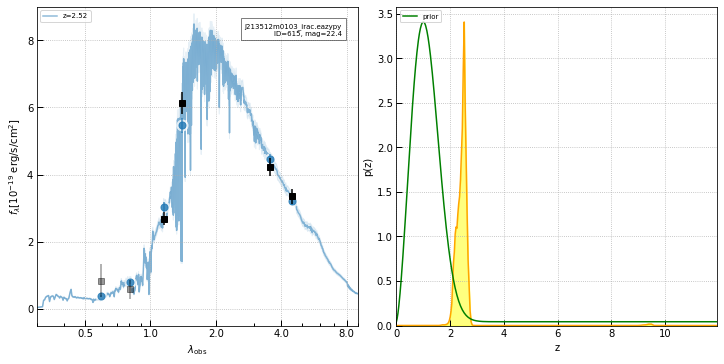

In [189]:
# SED of Repp z=9 candidate
id=615
fig, _ = self.show_fit(id, figsize=(10, 5))
fig.axes[0].set_ylim(-0.5, 9)

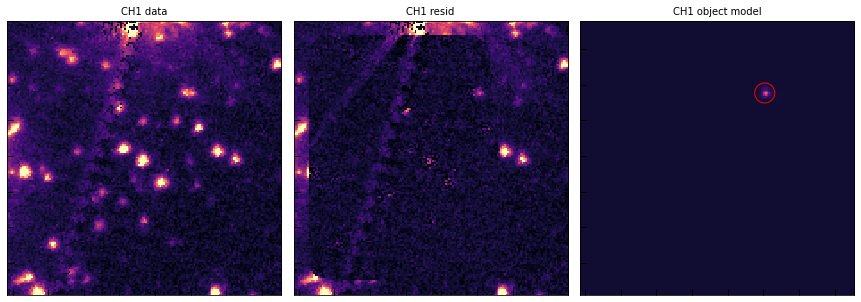

In [244]:
obj_model = ch1.comp_to_patch(id, full_image=True, flatten=False)

x, y = ch1.lores_wcs.all_world2pix(self.cat['ra'], self.cat['dec'], 0)
ix = self.cat['id'] == id

vm = (-0.2, 2)
cm = 'magma'

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
ax.imshow(ch1.lores_im.data, vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_title('CH1 data')

ax = fig.add_subplot(132)
ax.imshow(ch1.lores_im.data - (ch1.full_model - obj_model), vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_title('CH1 resid')

ax = fig.add_subplot(133)
ax.imshow(obj_model, vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_title('CH1 object model')

N = 30/0.5 # 20 arcsec
for ax in fig.axes:
    ax.set_xlim(ch1.patch_ll[0]-5, ch1.patch_ll[0]+ch1.patch_shape[1]+5)
    ax.set_ylim(ch1.patch_ll[1]-5, ch1.patch_ll[1]+ch1.patch_shape[0]+5)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

ax.scatter(x[ix], y[ix], marker='o', ec='r', fc='None', s=400)
fig.tight_layout(pad=0.5)

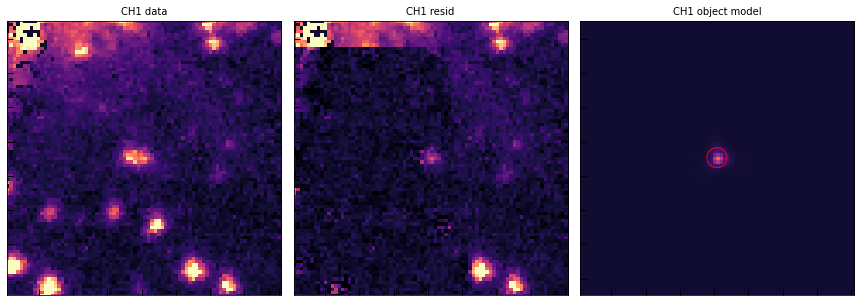

In [245]:
## Zoom in
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
ax.imshow(ch1.lores_im.data, vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_title('CH1 data')

ax = fig.add_subplot(132)
ax.imshow(ch1.lores_im.data - (ch1.full_model - obj_model), vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_title('CH1 resid')

ax = fig.add_subplot(133)
ax.imshow(obj_model, vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_title('CH1 object model')

N = 20/0.5 # 20 arcsec
for ax in fig.axes:
    ax.set_xlim(x[ix]-N, x[ix]+N)
    ax.set_ylim(y[ix]-N, y[ix]+N)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])

ax.scatter(x[ix], y[ix], marker='o', ec='r', fc='None', s=400)
fig.tight_layout(pad=0.5)

## Full-field automatic run

Rather than choosing a specific patch to run, can use the `run_all_patches` function to get IRAC photometry across the entire field over an automatic grid of patches.  For single WFC3/IR pointings, `patch_arcmin=1.5` should catch the entire field in a single patch, which is desirable to avoid issues at the overlaps.  For the general case, `patch_arcmin=1.0` seems to be a better compromise to be able to fit larger mosaics but with a patch large enough to reduce issues in the overlaps.

In [ ]:
kwargs['patch_arcmin'] = 1.0
golfir.model.run_all_patches(root, PATH=PATH, fetch=False, use_patches=True, sync_results=False, **kwargs)

PATH: ./, files:['./j213512m0103-f606w_drc_sci.fits', './j213512m0103-f110w_drz_sci.fits', './j213512m0103-f814w_drc_sci.fits', './j213512m0103-f140w_drz_sci.fits']
Use preferred r/g/b combination: ['f140w', 'f110w', 'f814w']
# field_rgb j213512m0103: r f140w / g f110w / b f814w
# (Sun Mar  8 10:36:45 2020)
Use HST reference image "j213512m0103-f140w_drz_sci.fits".
# (Sun Mar  8 10:36:46 2020)
Watershed segmentation dilation, smooth_size=5




0it [00:00, ?it/s]

# (Sun Mar  8 10:36:54 2020)
Read lores data: j213512m0103-ch1

# (Sun Mar  8 10:36:54 2020)
Read avg psf: /Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/golfir/data/psf/irsa_0.1pix_ch1_psf.fits

Read PSF data r20813056-ch1.log.fits / r20813056-ch1-0.1.psf.fits
Use rotated `avg_psf`.
get_exposure_time r20813056 (0/1)
# (Sun Mar  8 10:36:54 2020)
Read component file "j213512m0103-ch1_components.fits".
####################

Run ch1 patch 1/4

####################
# (Sun Mar  8 10:36:54 2020)
Get 1.0' patch around (323.80905, -1.05618)

# (Sun Mar  8 10:36:54 2020)
Compute 329 models for patch (mag_auto < 24.0)




1it [00:00,  4.75it/s]

2it [00:00,  4.70it/s]

3it [00:00,  4.72it/s]

4it [00:00,  4.75it/s]

5it [00:01,  4.81it/s]

6it [00:01,  4.83it/s]

7it [00:01,  4.82it/s]

8it [00:01,  4.80it/s]

9it [00:01,  4.80it/s]

10it [00:02,  4.79it/s]

11it [00:02,  4.79it/s]

12it [00:02,  4.83it/s]

13it [00:02,  4.78it/s]

14it [00:02,  4.79it/s]

15it [00:03,  4.81it/s]

16it [00:03,  4.82it/s]

17it [00:03,  4.80it/s]

18it [00:03,  4.80it/s]

19it [00:03,  4.84it/s]

20it [00:04,  4.86it/s]

21it [00:04,  4.85it/s]

22it [00:04,  4.73it/s]

23it [00:04,  4.77it/s]

24it [00:05,  4.74it/s]

25it [00:05,  4.72it/s]

26it [00:05,  4.76it/s]

27it [00:05,  4.80it/s]

28it [00:05,  4.84it/s]

29it [00:06,  4.82it/s]

30it [00:06,  4.80it/s]

31it [00:06,  4.83it/s]

32it [00:06,  4.80it/s]

33it [00:06,  4.72it/s]

34it [00:07,  4.74it/s]

35it [00:07,  4.73it/s]

36it [00:07,  4.74it/s]

37it [00:07,  4.71it/s]

38it [00:07,  4.65it/s]

39it [00:08,  4.68it/s]

40it [00:08,  4.64it/s]

41it [0

260it [00:56,  4.47it/s]

261it [00:57,  4.46it/s]

262it [00:57,  4.49it/s]

263it [00:57,  4.52it/s]

264it [00:57,  4.49it/s]

265it [00:58,  4.50it/s]

266it [00:58,  4.55it/s]

267it [00:58,  4.60it/s]

268it [00:58,  4.62it/s]

269it [00:58,  4.62it/s]

270it [00:59,  4.58it/s]

271it [00:59,  4.56it/s]

272it [00:59,  4.56it/s]

273it [00:59,  4.57it/s]

274it [01:00,  4.58it/s]

275it [01:00,  4.59it/s]

276it [01:00,  4.59it/s]

277it [01:00,  4.58it/s]

278it [01:00,  4.60it/s]

279it [01:01,  4.63it/s]

280it [01:01,  4.60it/s]

281it [01:01,  4.58it/s]

282it [01:01,  4.53it/s]

283it [01:01,  4.62it/s]

284it [01:02,  4.58it/s]

285it [01:02,  4.64it/s]

286it [01:02,  4.62it/s]

287it [01:02,  4.61it/s]

288it [01:03,  4.57it/s]

289it [01:03,  4.54it/s]

290it [01:03,  4.55it/s]

291it [01:03,  4.57it/s]

292it [01:03,  4.58it/s]

293it [01:04,  4.59it/s]

294it [01:04,  4.61it/s]

295it [01:04,  4.59it/s]

296it [01:04,  4.58it/s]

297it [01:05,  4.58it/s]

298it [01:05

# (Sun Mar  8 10:38:07 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:38:07 2020)
Patch least squares
[0. 0. 0. 1.] 97859.41127176482
[0. 0. 0. 1.] 97859.41127176482
[0.1 0.  0.  1. ] 93214.50461614192
[0.2618034 0.        0.        1.       ] 90036.9925249327
[0.27678268 0.         0.         1.        ] 90040.22055944467
[0.2618034 0.        0.        1.       ] 90036.9925249327
[0.2 0.  0.  1. ] 90571.72650409634
[0.2381966 0.        0.        1.       ] 90138.09054082484
[0.26871798 0.         0.         1.        ] 90031.93725606547
[0.2660308 0.        0.        1.       ] 90032.57160558295
[0.27140516 0.         0.         1.        ] 90032.99763683611
[0.26871798 0.         0.         1.        ] 90031.93725606547
[0.26871798 0.1        0.         1.        ] 93747.12724098147
[ 0.26871798 -0.1618034   0.          1.        ] 87760.01060599583
[ 0.26871798 -0.16043341  0.        

[ 0.26264728 -0.14690096  0.03121191  0.99965616] 87539.22673899417
# (Sun Mar  8 10:38:09 2020)
Patch 000, transform: (1.31, -0.73)  0.031 1.000
# (Sun Mar  8 10:38:11 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:38:11 2020)
Patch least squares




0it [00:00, ?it/s]

# (Sun Mar  8 10:38:12 2020)
Compute 559 models for patch (mag_auto < 27.0)




1it [00:00,  4.86it/s]

2it [00:00,  4.85it/s]

3it [00:00,  4.78it/s]

4it [00:00,  4.77it/s]

5it [00:01,  4.77it/s]

6it [00:01,  4.70it/s]

7it [00:01,  4.63it/s]

8it [00:01,  4.57it/s]

9it [00:01,  4.54it/s]

10it [00:02,  4.55it/s]

11it [00:02,  4.56it/s]

12it [00:02,  4.54it/s]

13it [00:02,  4.60it/s]

14it [00:03,  4.61it/s]

15it [00:03,  4.57it/s]

16it [00:03,  4.51it/s]

17it [00:03,  4.50it/s]

18it [00:03,  4.50it/s]

19it [00:04,  4.48it/s]

20it [00:04,  4.46it/s]

21it [00:04,  4.49it/s]

22it [00:04,  4.51it/s]

23it [00:05,  4.51it/s]

24it [00:05,  4.49it/s]

25it [00:05,  4.48it/s]

26it [00:05,  4.41it/s]

27it [00:05,  4.39it/s]

28it [00:06,  4.41it/s]

29it [00:06,  4.44it/s]

30it [00:06,  4.42it/s]

31it [00:06,  4.42it/s]

32it [00:07,  4.37it/s]

33it [00:07,  4.42it/s]

34it [00:07,  4.51it/s]

35it [00:07,  4.52it/s]

36it [00:07,  4.54it/s]

37it [00:08,  4.54it/s]

38it [00:08,  4.53it/s]

39it [00:08,  4.54it/s]

40it [00:08,  4.52it/s]

41it [0

260it [00:57,  4.55it/s]

261it [00:57,  4.57it/s]

262it [00:57,  4.56it/s]

263it [00:57,  4.57it/s]

264it [00:57,  4.54it/s]

265it [00:58,  4.56it/s]

266it [00:58,  4.55it/s]

267it [00:58,  4.54it/s]

268it [00:58,  4.53it/s]

269it [00:59,  4.54it/s]

270it [00:59,  4.56it/s]

271it [00:59,  4.54it/s]

272it [00:59,  4.54it/s]

273it [00:59,  4.53it/s]

274it [01:00,  4.58it/s]

275it [01:00,  4.50it/s]

276it [01:00,  4.47it/s]

277it [01:00,  4.49it/s]

278it [01:01,  4.48it/s]

279it [01:01,  4.52it/s]

280it [01:01,  4.53it/s]

281it [01:01,  4.52it/s]

282it [01:01,  4.52it/s]

283it [01:02,  4.52it/s]

284it [01:02,  4.48it/s]

285it [01:02,  4.49it/s]

286it [01:02,  4.52it/s]

287it [01:03,  4.51it/s]

288it [01:03,  4.53it/s]

289it [01:03,  4.51it/s]

290it [01:03,  4.51it/s]

291it [01:03,  4.51it/s]

292it [01:04,  4.50it/s]

293it [01:04,  4.49it/s]

294it [01:04,  4.50it/s]

295it [01:04,  4.53it/s]

296it [01:05,  4.53it/s]

297it [01:05,  4.53it/s]

298it [01:05

516it [01:53,  4.59it/s]

517it [01:53,  4.60it/s]

518it [01:53,  4.60it/s]

519it [01:54,  4.59it/s]

520it [01:54,  4.59it/s]

521it [01:54,  4.57it/s]

522it [01:54,  4.55it/s]

523it [01:55,  4.53it/s]

524it [01:55,  4.53it/s]

525it [01:55,  4.55it/s]

526it [01:55,  4.53it/s]

527it [01:55,  4.54it/s]

528it [01:56,  4.53it/s]

529it [01:56,  4.52it/s]

530it [01:56,  4.54it/s]

531it [01:56,  4.54it/s]

532it [01:57,  4.51it/s]

533it [01:57,  4.56it/s]

534it [01:57,  4.59it/s]

535it [01:57,  4.56it/s]

536it [01:57,  4.56it/s]

537it [01:58,  4.56it/s]

538it [01:58,  4.55it/s]

539it [01:58,  4.52it/s]

540it [01:58,  4.51it/s]

541it [01:59,  4.54it/s]

542it [01:59,  4.54it/s]

543it [01:59,  4.55it/s]

544it [01:59,  4.55it/s]

545it [01:59,  4.52it/s]

546it [02:00,  4.54it/s]

547it [02:00,  4.52it/s]

548it [02:00,  4.50it/s]

549it [02:00,  4.50it/s]

550it [02:00,  4.51it/s]

551it [02:01,  4.46it/s]

552it [02:01,  4.42it/s]

553it [02:01,  4.42it/s]

554it [02:01

# (Sun Mar  8 10:40:16 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:40:16 2020)
Patch least squares
# (Sun Mar  8 10:40:17 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:40:17 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': [], 'bright_sn': 30}
# (Sun Mar  8 10:40:17 2020)
Patch least squares




0it [00:00, ?it/s]

1it [00:00,  5.01it/s]

8it [00:00,  6.94it/s]

16it [00:00,  9.53it/s]

24it [00:00, 12.92it/s]

32it [00:00, 17.15it/s]

39it [00:00, 22.07it/s]

47it [00:00, 27.81it/s]

54it [00:00, 33.81it/s]

61it [00:01, 39.72it/s]

68it [00:01, 45.16it/s]

75it [00:01, 47.52it/s]

82it [00:01, 50.22it/s]

89it [00:01, 53.26it/s]

96it [00:01, 55.68it/s]

103it [00:01, 55.48it/s]

110it [00:01, 56.99it/s]

116it [00:01, 57.59it/s]

122it [00:02, 58.15it/s]

128it [00:02, 56.00it/s]

134it [00:02, 54.60it/s]

140it [00:02, 54.82it/s]

146it [00:02, 55.03it/s]

152it [00:02, 50.73it/s]

158it [00:02, 47.84it/s]

163it [00:02, 45.33it/s]

168it [00:03, 44.79it/s]

173it [00:03, 45.23it/s]

178it [00:03, 45.80it/s]

183it [00:03, 46.28it/s]

188it [00:03, 46.92it/s]

193it [00:03, 44.00it/s]

198it [00:03, 42.72it/s]

203it [00:03, 43.52it/s]

208it [00:03, 44.87it/s]

213it [00:04, 45.73it/s]

219it [00:04, 47.87it/s]

224it [00:04, 47.73it/s]

229it [00:04, 46.56it/s]

234it 

####################

Run ch1 patch 2/4

####################
# (Sun Mar  8 10:40:34 2020)
Get 1.0' patch around (323.77905, -1.05618)

# (Sun Mar  8 10:40:34 2020)
Compute 172 models for patch (mag_auto < 24.0)




1it [00:00,  4.85it/s]

2it [00:00,  4.83it/s]

3it [00:00,  4.80it/s]

4it [00:00,  4.85it/s]

5it [00:01,  4.78it/s]

6it [00:01,  4.77it/s]

7it [00:01,  4.79it/s]

8it [00:01,  4.73it/s]

9it [00:01,  4.77it/s]

10it [00:02,  4.82it/s]

11it [00:02,  4.82it/s]

12it [00:02,  4.84it/s]

13it [00:02,  4.74it/s]

14it [00:02,  4.67it/s]

15it [00:03,  4.60it/s]

16it [00:03,  4.58it/s]

17it [00:03,  4.61it/s]

18it [00:03,  4.65it/s]

19it [00:04,  4.62it/s]

20it [00:04,  4.59it/s]

21it [00:04,  4.59it/s]

22it [00:04,  4.64it/s]

23it [00:04,  4.69it/s]

24it [00:05,  4.73it/s]

25it [00:05,  4.74it/s]

26it [00:05,  4.76it/s]

27it [00:05,  4.77it/s]

28it [00:05,  4.79it/s]

29it [00:06,  4.74it/s]

30it [00:06,  4.77it/s]

31it [00:06,  4.77it/s]

32it [00:06,  4.76it/s]

33it [00:06,  4.77it/s]

34it [00:07,  4.72it/s]

35it [00:07,  4.72it/s]

36it [00:07,  4.73it/s]

37it [00:07,  4.76it/s]

38it [00:08,  4.77it/s]

39it [00:08,  4.74it/s]

40it [00:08,  4.76it/s]

41it [0

# (Sun Mar  8 10:41:12 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:41:12 2020)
Patch least squares
[0. 0. 0. 1.] 27933.611594758404
[0. 0. 0. 1.] 27933.611594758404
[0.1 0.  0.  1. ] 26539.46267888494
[0.2618034 0.        0.        1.       ] 25106.118063306993
[0.40903776 0.         0.         1.        ] 24883.796898119683
[0.64726796 0.         0.         1.        ] 26951.047711475767
[0.40903776 0.         0.         1.        ] 24883.796898119683
[0.5000336 0.        0.        1.       ] 25318.64338532451
[0.35279924 0.         0.         1.        ] 24836.551053342853
[0.36521628 0.         0.         1.        ] 24832.621606591136
[0.36156412 0.         0.         1.        ] 24832.939118830884
[0.36886844 0.         0.         1.        ] 24833.004715478713
[0.36521628 0.         0.         1.        ] 24832.621606591136
[0.36521628 0.1        0.         1.        ] 26503.510

[ 3.58010026e-01 -3.76418838e-01 -9.33640194e-06  1.00051781e+00] 21846.400860137088
[ 0.35801003 -0.37641884 -0.61804331  1.00051781] 41648.12427496824
[ 0.35801003 -0.37641884  0.38195666  1.00051781] 29503.46395699561
[ 0.35801003 -0.37641884 -0.00146126  1.00051781] 21846.759233777546
[ 0.35801003 -0.37641884  0.00159646  1.00051781] 21847.455605841198
[ 3.58010026e-01 -3.76418838e-01 -3.17703388e-04  1.00051781e+00] 21846.45737877157
[ 3.58010026e-01 -3.76418838e-01  6.04023319e-04  1.00051781e+00] 21846.766725903773
[ 3.58010026e-01 -3.76418838e-01  2.24946157e-04  1.00051781e+00] 21846.531555871545
[ 3.58010026e-01 -3.76418838e-01 -9.64212633e-05  1.00051781e+00] 21846.41575033509
[ 3.58010026e-01 -3.76418838e-01  8.01515701e-05  1.00051781e+00] 21846.445809206733
[ 3.58010026e-01 -3.76418838e-01 -3.04576696e-05  1.00051781e+00] 21846.40439411627
[ 3.58010026e-01 -3.76418838e-01  2.48449608e-05  1.00051781e+00] 21846.41365226826
[ 3.58010026e-01 -3.76418838e-01 -1.13540023e-05  



0it [00:00, ?it/s]

# (Sun Mar  8 10:41:15 2020)
Compute 277 models for patch (mag_auto < 27.0)




1it [00:00,  4.87it/s]

2it [00:00,  4.79it/s]

3it [00:00,  4.77it/s]

4it [00:00,  4.65it/s]

5it [00:01,  4.61it/s]

6it [00:01,  4.58it/s]

7it [00:01,  4.53it/s]

8it [00:01,  4.55it/s]

9it [00:01,  4.59it/s]

10it [00:02,  4.59it/s]

11it [00:02,  4.64it/s]

12it [00:02,  4.68it/s]

13it [00:02,  4.64it/s]

14it [00:03,  4.62it/s]

15it [00:03,  4.65it/s]

16it [00:03,  4.66it/s]

17it [00:03,  4.66it/s]

18it [00:03,  4.66it/s]

19it [00:04,  4.64it/s]

20it [00:04,  4.63it/s]

21it [00:04,  4.59it/s]

22it [00:04,  4.61it/s]

23it [00:04,  4.63it/s]

24it [00:05,  4.64it/s]

25it [00:05,  4.65it/s]

26it [00:05,  4.67it/s]

27it [00:05,  4.62it/s]

28it [00:06,  4.62it/s]

29it [00:06,  4.64it/s]

30it [00:06,  4.65it/s]

31it [00:06,  4.65it/s]

32it [00:06,  4.61it/s]

33it [00:07,  4.61it/s]

34it [00:07,  4.60it/s]

35it [00:07,  4.58it/s]

36it [00:07,  4.40it/s]

37it [00:08,  4.45it/s]

38it [00:08,  4.50it/s]

39it [00:08,  4.53it/s]

40it [00:08,  4.57it/s]

41it [0

260it [00:58,  4.27it/s]

261it [00:58,  4.35it/s]

262it [00:58,  4.40it/s]

263it [00:59,  4.44it/s]

264it [00:59,  4.47it/s]

265it [00:59,  4.47it/s]

266it [00:59,  4.50it/s]

267it [01:00,  4.52it/s]

268it [01:00,  4.55it/s]

269it [01:00,  4.55it/s]

270it [01:00,  4.56it/s]

271it [01:00,  4.56it/s]

272it [01:01,  4.55it/s]

273it [01:01,  4.57it/s]

274it [01:01,  4.59it/s]

275it [01:01,  4.56it/s]

276it [01:01,  4.51it/s]

277it [01:02,  4.54it/s]

# (Sun Mar  8 10:42:18 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:42:18 2020)
Patch least squares
# (Sun Mar  8 10:42:18 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:42:18 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': [], 'bright_sn': 30}
# (Sun Mar  8 10:42:18 2020)
Patch least squares




0it [00:00, ?it/s]

4it [00:00, 33.67it/s]

7it [00:00, 32.40it/s]

10it [00:00, 30.09it/s]

14it [00:00, 31.49it/s]

18it [00:00, 31.90it/s]

22it [00:00, 31.63it/s]

26it [00:00, 31.38it/s]

30it [00:00, 32.00it/s]

34it [00:01, 31.63it/s]

38it [00:01, 32.43it/s]

42it [00:01, 31.68it/s]

46it [00:01, 31.02it/s]

50it [00:01, 29.93it/s]

54it [00:01, 30.43it/s]

58it [00:01, 30.75it/s]

62it [00:01, 31.62it/s]

66it [00:02, 32.27it/s]

70it [00:02, 32.98it/s]

74it [00:02, 33.80it/s]

80it [00:02, 38.72it/s]

86it [00:02, 41.90it/s]

92it [00:02, 44.92it/s]

97it [00:02, 43.60it/s]

102it [00:02, 42.34it/s]

108it [00:03, 44.80it/s]

113it [00:03, 45.05it/s]

119it [00:03, 46.83it/s]

125it [00:03, 50.01it/s]

131it [00:03, 50.88it/s]

137it [00:03, 48.60it/s]

142it [00:03, 47.14it/s]

147it [00:03, 46.38it/s]

152it [00:03, 46.82it/s]

157it [00:04, 47.66it/s]

162it [00:04, 47.04it/s]

167it [00:04, 46.27it/s]

172it [00:04, 42.01it/s]

177it [00:04, 43.51it/s]

182it [00:04, 4

####################

Run ch1 patch 3/4

####################
# (Sun Mar  8 10:42:27 2020)
Get 1.0' patch around (323.80905, -1.02618)

# (Sun Mar  8 10:42:27 2020)
Compute 95 models for patch (mag_auto < 24.0)




1it [00:00,  4.58it/s]

2it [00:00,  4.64it/s]

3it [00:00,  4.68it/s]

4it [00:00,  4.74it/s]

5it [00:01,  4.78it/s]

6it [00:01,  4.76it/s]

7it [00:01,  4.65it/s]

8it [00:01,  4.65it/s]

9it [00:01,  4.68it/s]

10it [00:02,  4.72it/s]

11it [00:02,  4.64it/s]

12it [00:02,  4.65it/s]

13it [00:02,  4.67it/s]

14it [00:02,  4.66it/s]

15it [00:03,  4.65it/s]

16it [00:03,  4.68it/s]

17it [00:03,  4.70it/s]

18it [00:03,  4.71it/s]

19it [00:04,  4.77it/s]

20it [00:04,  4.78it/s]

21it [00:04,  4.83it/s]

22it [00:04,  4.82it/s]

23it [00:04,  4.78it/s]

24it [00:05,  4.80it/s]

25it [00:05,  4.77it/s]

26it [00:05,  4.72it/s]

27it [00:05,  4.66it/s]

28it [00:05,  4.64it/s]

29it [00:06,  4.65it/s]

30it [00:06,  4.60it/s]

31it [00:06,  4.61it/s]

32it [00:06,  4.61it/s]

33it [00:07,  4.60it/s]

34it [00:07,  4.59it/s]

35it [00:07,  4.52it/s]

36it [00:07,  4.47it/s]

37it [00:07,  4.44it/s]

38it [00:08,  4.49it/s]

39it [00:08,  4.44it/s]

40it [00:08,  4.44it/s]

41it [0

# (Sun Mar  8 10:42:48 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:42:48 2020)
Patch least squares
[0. 0. 0. 1.] 66923.63811337965
[0. 0. 0. 1.] 66923.63811337965
[0.1 0.  0.  1. ] 64746.691566136695
[0.2618034 0.        0.        1.       ] 63429.256229971565
[0.25911456 0.         0.         1.        ] 63426.90520933731
[0.25911456 0.         0.         1.        ] 63426.90520933731
[0.19833821 0.         0.         1.        ] 63598.65078181977
[0.23590006 0.         0.         1.        ] 63442.01445315629
[0.25312735 0.         0.         1.        ] 63424.74203669247
[0.25059608 0.         0.         1.        ] 63425.09907930488
[0.25565863 0.         0.         1.        ] 63425.14005142056
[0.25312735 0.         0.         1.        ] 63424.74203669247
[0.25312735 0.1        0.         1.        ] 63646.95290321541
[ 0.25312735 -0.1618034   0.          1.        ] 65224.1030

[ 0.27399338 -0.04914329  0.          0.99903466] 63304.05459046914
[ 0.27020117 -0.03492898  0.          0.99917592] 63303.32992846701
[ 0.27150515 -0.0398167   0.          0.99912735] 63302.99121155302
[ 0.27136209 -0.03928045  0.          0.99913267] 63302.998322220745
[ 0.27150515 -0.0398167   0.          0.99912735] 63302.99121155302
[ 0.37150515 -0.0398167   0.          0.99912735] 63968.22393425482
[ 0.10970175 -0.0398167   0.          0.99912735] 64696.38426032183
[ 0.27150515 -0.0398167   0.          0.99912735] 63302.99121155302
[ 0.20970176 -0.0398167   0.          0.99912735] 63489.980506634645
[ 0.30970175 -0.0398167   0.          0.99912735] 63412.86254837357
[ 0.26623494 -0.0398167   0.          0.99912735] 63301.53572342447
[ 0.26656178 -0.0398167   0.          0.99912735] 63301.530274300116
[ 0.26651235 -0.0398167   0.          0.99912735] 63301.530287035916
[ 0.26661122 -0.0398167   0.          0.99912735] 63301.530550775
[ 0.26656178 -0.0398167   0.          0.999127



0it [00:00, ?it/s]

# (Sun Mar  8 10:42:51 2020)
Compute 171 models for patch (mag_auto < 27.0)




1it [00:00,  4.79it/s]

2it [00:00,  4.75it/s]

3it [00:00,  4.64it/s]

4it [00:00,  4.54it/s]

5it [00:01,  4.51it/s]

6it [00:01,  4.51it/s]

7it [00:01,  4.50it/s]

8it [00:01,  4.53it/s]

9it [00:01,  4.55it/s]

10it [00:02,  4.58it/s]

11it [00:02,  4.59it/s]

12it [00:02,  4.60it/s]

13it [00:02,  4.58it/s]

14it [00:03,  4.58it/s]

15it [00:03,  4.61it/s]

16it [00:03,  4.62it/s]

17it [00:03,  4.60it/s]

18it [00:03,  4.59it/s]

19it [00:04,  4.59it/s]

20it [00:04,  4.60it/s]

21it [00:04,  4.54it/s]

22it [00:04,  4.59it/s]

23it [00:05,  4.59it/s]

24it [00:05,  4.59it/s]

25it [00:05,  4.61it/s]

26it [00:05,  4.60it/s]

27it [00:05,  4.59it/s]

28it [00:06,  4.59it/s]

29it [00:06,  4.61it/s]

30it [00:06,  4.62it/s]

31it [00:06,  4.60it/s]

32it [00:06,  4.61it/s]

33it [00:07,  4.62it/s]

34it [00:07,  4.59it/s]

35it [00:07,  4.59it/s]

36it [00:07,  4.61it/s]

37it [00:08,  4.56it/s]

38it [00:08,  4.54it/s]

39it [00:08,  4.53it/s]

40it [00:08,  4.54it/s]

41it [0

# (Sun Mar  8 10:43:29 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:43:29 2020)
Patch least squares
# (Sun Mar  8 10:43:30 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:43:30 2020)
patch_galfit:    fit_ids = [844]
patch_galfit:  chi2_init = 1133.06
patch_galfit: chi2_final = 73.22
patch_galfit:       diff = 7697595.9
# (Sun Mar  8 10:43:30 2020)
insert_galfit_models: {'id': 844, 'type': 'psf', 'll': array([ 824, 1011]), 'xc': (152.2572, 0), 'yc': (48.6513, 0), 'mag': (18.1878, 0)}
# (Sun Mar  8 10:43:30 2020)
Patch least squares
# (Sun Mar  8 10:43:33 2020)
patch_galfit:    fit_ids = [844]
patch_galfit:  chi2_init = 91.29
patch_galfit: chi2_final = 205.58
patch_galfit:       diff = -830075.8
# (Sun Mar  8 10:43:33 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point



0it [00:00, ?it/s]

3it [00:00, 27.56it/s]

6it [00:00, 26.69it/s]

9it [00:00, 25.94it/s]

13it [00:00, 27.27it/s]

16it [00:00, 27.95it/s]

19it [00:00, 28.05it/s]

22it [00:00, 26.65it/s]

25it [00:00, 24.43it/s]

28it [00:01, 24.14it/s]

31it [00:01, 24.85it/s]

34it [00:01, 25.59it/s]

37it [00:01, 25.91it/s]

40it [00:01, 26.24it/s]

43it [00:01, 25.52it/s]

46it [00:01, 25.04it/s]

49it [00:01, 24.78it/s]

52it [00:02, 24.46it/s]

55it [00:02, 23.93it/s]

58it [00:02, 24.20it/s]

61it [00:02, 24.83it/s]

64it [00:02, 25.23it/s]

67it [00:02, 24.66it/s]

70it [00:02, 25.52it/s]

73it [00:02, 25.38it/s]

76it [00:03, 24.63it/s]

79it [00:03, 24.13it/s]

82it [00:03, 25.19it/s]

85it [00:03, 25.27it/s]

88it [00:03, 25.00it/s]

91it [00:03, 24.93it/s]

94it [00:03, 25.05it/s]

97it [00:03, 25.16it/s]

100it [00:03, 24.95it/s]

103it [00:04, 24.63it/s]

106it [00:04, 24.63it/s]

109it [00:04, 24.67it/s]

112it [00:04, 24.50it/s]

115it [00:04, 24.22it/s]

118it [00:04, 24.19it/s]


Galfit component: 844




157it [00:06, 23.19it/s]

160it [00:06, 23.35it/s]

163it [00:06, 23.42it/s]

166it [00:06, 23.55it/s]

169it [00:06, 23.49it/s]

171it [00:06, 24.64it/s]

0it [00:00, ?it/s]

####################

Run ch1 patch 4/4

####################
# (Sun Mar  8 10:43:42 2020)
Get 1.0' patch around (323.77905, -1.02618)

# (Sun Mar  8 10:43:42 2020)
Compute 47 models for patch (mag_auto < 24.0)




1it [00:00,  4.98it/s]

2it [00:00,  4.95it/s]

3it [00:00,  4.86it/s]

4it [00:00,  4.86it/s]

5it [00:01,  4.80it/s]

6it [00:01,  4.77it/s]

7it [00:01,  4.73it/s]

8it [00:01,  4.68it/s]

9it [00:01,  4.65it/s]

10it [00:02,  4.66it/s]

11it [00:02,  4.60it/s]

12it [00:02,  4.56it/s]

13it [00:02,  4.57it/s]

14it [00:03,  4.59it/s]

15it [00:03,  4.62it/s]

16it [00:03,  4.65it/s]

17it [00:03,  4.67it/s]

18it [00:03,  4.69it/s]

19it [00:04,  4.77it/s]

20it [00:04,  4.72it/s]

21it [00:04,  4.71it/s]

22it [00:04,  4.72it/s]

23it [00:04,  4.75it/s]

24it [00:05,  4.76it/s]

25it [00:05,  4.77it/s]

26it [00:05,  4.80it/s]

27it [00:05,  4.75it/s]

28it [00:05,  4.73it/s]

29it [00:06,  4.75it/s]

30it [00:06,  4.74it/s]

31it [00:06,  4.76it/s]

32it [00:06,  4.75it/s]

33it [00:07,  4.73it/s]

34it [00:07,  4.66it/s]

35it [00:07,  4.64it/s]

36it [00:07,  4.63it/s]

37it [00:07,  4.67it/s]

38it [00:08,  4.66it/s]

39it [00:08,  4.61it/s]

40it [00:08,  4.58it/s]

41it [0

# (Sun Mar  8 10:43:52 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:43:52 2020)
Patch least squares
[0. 0. 0. 1.] 150679.79037505042
[0. 0. 0. 1.] 150679.79037505042
[0.1 0.  0.  1. ] 150144.21475505037
[0.2618034 0.        0.        1.       ] 151282.74751734023
[0.1 0.  0.  1. ] 150144.21475505037
[0.1618034 0.        0.        1.       ] 150279.70256009648
[0.0618034 0.        0.        1.       ] 150240.38259242114
[0.10762926 0.         0.         1.        ] 150141.33704031928
[0.10870555 0.         0.         1.        ] 150141.3719299266
[0.10655296 0.         0.         1.        ] 150141.4112704845
[0.10762926 0.         0.         1.        ] 150141.33704031928
[0.10762926 0.1        0.         1.        ] 154610.83248302096
[ 0.10762926 -0.1618034   0.          1.        ] 144721.96227568126
[ 0.10762926 -0.47231486  0.          1.        ] 141191.69482129448
[ 0.10762926 -

[ 1.22833962e-01 -3.89112220e-01 -2.63879556e-07  1.00057914e+00] 140874.4054283308
[ 1.22833962e-01 -3.89112220e-01  2.37323574e-08  1.00057914e+00] 140874.40304014707
[ 1.22833962e-01 -3.89112220e-01 -1.00793018e-07  1.00057914e+00] 140874.40389877296
[ 1.22833962e-01 -3.89112220e-01 -3.84995061e-08  1.00057914e+00] 140874.40331453545
[ 1.22833962e-01 -3.89112220e-01  3.14424160e-09  1.00057914e+00] 140874.4029649425
[ 1.22833962e-01 -3.89112220e-01 -1.47055023e-08  1.00057914e+00] 140874.4030913767
[ 1.22833962e-01 -3.89112220e-01 -5.61700191e-09  1.00057914e+00] 140874.40300613779
[ 1.22833962e-01 -3.89112220e-01  3.44212543e-10  1.00057914e+00] 140874.40295471443
[ 1.22833962e-01 -3.89112220e-01 -2.14550375e-09  1.00057914e+00] 140874.40297357933
[ 1.22833962e-01 -3.89112220e-01 -8.19509486e-10  1.00057914e+00] 140874.4029611432
[ 1.22833962e-01 -3.89112220e-01  1.00000000e-11  1.00057914e+00] 140874.40295349382
[ 1.22833962e-01 -3.89112220e-01 -3.13024760e-10  1.00057914e+00] 140

[0.50921421 0.20207091 0.         1.0127997 ] 143930.05218495993
[0.50921421 0.20207091 0.         1.00905802] 139003.68831582405
[0.50921421 0.20207091 0.         1.00897765] 139001.51198469795
[0.50921421 0.20207091 0.         1.00897949] 139001.51078314974
[0.50921421 0.20207091 0.         1.00897948] 139001.51078315655
[0.50921421 0.20207091 0.         1.0089795 ] 139001.51078316354
[0.50921421 0.20207091 0.         1.00897949] 139001.51078314974
[0.50921421 0.20207091 1.         1.00897949] 265885.3102124912
[ 0.50921421  0.20207091 -1.618034    1.00897949] 401489.70168070827
[0.50921421 0.20207091 0.         1.00897949] 139001.51078314974
[ 0.50921421  0.20207091 -0.61803397  1.00897949] 181710.06494816538
[0.50921421 0.20207091 0.381966   1.00897949] 160194.06798929986
[ 0.50921421  0.20207091 -0.03168451  1.00897949] 139151.91860373487
[5.09214211e-01 2.02070910e-01 4.58767874e-04 1.00897949e+00] 139006.75628728632
[ 0.50921421  0.20207091 -0.01112728  1.00897949] 139028.407858

[ 0.91062126  0.76026042 -0.01099104  1.01668389] 138622.87025739218
[ 0.9084867   0.75754506 -0.0109074   1.01664535] 138622.86884213184
[ 0.90955398  0.75890274 -0.01094922  1.01666462] 138622.86590466026
[ 1.05278212  0.99743736 -0.01094922  1.01979234] 139033.31968811064
[ 0.67780597  0.37294561 -0.01094922  1.01160386] 138608.2492478799
[ 0.78946073  0.55889737 -0.01094922  1.0140421 ] 138512.6858555227
[ 0.78946073  0.55889737 -0.01094922  1.0140421 ] 138512.6858555227
[ 0.83533227  0.63529262 -0.01094922  1.01504381] 138529.14899292882
[ 0.7468124   0.48787012 -0.01094922  1.01311077] 138526.30985467596
[ 0.78825979  0.55689731 -0.01094922  1.01401587] 138512.68667380462
[ 0.79066166  0.56089742 -0.01094922  1.01406832] 138512.70715119538
[ 0.78946073  0.55889737 -0.01094922  1.0140421 ] 138512.6858555227
[ 0.78946073  0.55889737 -0.01094922  1.0240421 ] 170119.46288856043
[ 0.78946073  0.55889737 -0.01094922  0.99786176] 238503.60764463135
[ 0.78946073  0.55889737 -0.01094922  

[0.9933491  0.73912857 0.00164012 1.01699867] 138260.28204819572
[0.99275948 0.73837851 0.00166323 1.01698802] 138260.28217795753
[0.99305429 0.73875354 0.00165168 1.01699334] 138260.28181431346
[0.99305429 0.73875354 0.00165168 1.02699334] 169912.72323874707
[0.99305429 0.73875354 0.00165168 1.000813  ] 239244.32486031682
[0.99305429 0.73875354 0.00165168 1.01699334] 138260.28181431346
[0.99305429 0.73875354 0.00165168 1.010813  ] 152165.26451583952
[0.99305429 0.73875354 0.00165168 1.020813  ] 143192.2455720834
[0.99305429 0.73875354 0.00165168 1.01707999] 138262.69312027766
[0.99305429 0.73875354 0.00165168 1.01699555] 138260.27749032428
[0.99305429 0.73875354 0.00165168 1.01699722] 138260.27651339836
[0.99305429 0.73875354 0.00165168 1.01699718] 138260.27651387473
[0.99305429 0.73875354 0.00165168 1.01699726] 138260.27651398326
[0.99305429 0.73875354 0.00165168 1.01699722] 138260.27651339836
[0.99305429 0.73875354 1.00165168 1.01699722] 259979.63497472004
[ 0.99305429  0.73875354 -



0it [00:00, ?it/s]

# (Sun Mar  8 10:43:57 2020)
Compute 70 models for patch (mag_auto < 27.0)




1it [00:00,  4.68it/s]

2it [00:00,  4.63it/s]

3it [00:00,  4.62it/s]

4it [00:00,  4.58it/s]

5it [00:01,  4.56it/s]

6it [00:01,  4.54it/s]

7it [00:01,  4.54it/s]

8it [00:01,  4.52it/s]

9it [00:01,  4.54it/s]

10it [00:02,  4.52it/s]

11it [00:02,  4.53it/s]

12it [00:02,  4.54it/s]

13it [00:02,  4.55it/s]

14it [00:03,  4.58it/s]

15it [00:03,  4.57it/s]

16it [00:03,  4.56it/s]

17it [00:03,  4.53it/s]

18it [00:03,  4.50it/s]

19it [00:04,  4.48it/s]

20it [00:04,  4.47it/s]

21it [00:04,  4.42it/s]

22it [00:04,  4.36it/s]

23it [00:05,  4.35it/s]

24it [00:05,  4.34it/s]

25it [00:05,  4.33it/s]

26it [00:05,  4.33it/s]

27it [00:06,  4.33it/s]

28it [00:06,  4.32it/s]

29it [00:06,  4.32it/s]

30it [00:06,  4.37it/s]

31it [00:06,  4.43it/s]

32it [00:07,  4.49it/s]

33it [00:07,  4.47it/s]

34it [00:07,  4.48it/s]

35it [00:07,  4.51it/s]

36it [00:08,  4.48it/s]

37it [00:08,  4.50it/s]

38it [00:08,  4.55it/s]

39it [00:08,  4.55it/s]

40it [00:08,  4.49it/s]

41it [0

# (Sun Mar  8 10:44:13 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:44:13 2020)
Patch least squares
# (Sun Mar  8 10:44:13 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:44:13 2020)
Set bright target mask: {'any_limit': 10, 'point_limit': 10, 'point_flux_radius': 3.5, 'bright_ids': [], 'bright_sn': 30}
# (Sun Mar  8 10:44:13 2020)
Patch least squares




0it [00:00, ?it/s]

2it [00:00, 18.88it/s]

5it [00:00, 19.83it/s]

8it [00:00, 20.36it/s]

10it [00:00, 19.78it/s]

12it [00:00, 19.83it/s]

15it [00:00, 20.38it/s]

18it [00:00, 20.92it/s]

20it [00:00, 20.54it/s]

22it [00:01, 19.74it/s]

24it [00:01, 18.73it/s]

26it [00:01, 18.64it/s]

29it [00:01, 19.29it/s]

31it [00:01, 19.44it/s]

33it [00:01, 19.17it/s]

35it [00:01, 18.82it/s]

37it [00:01, 18.98it/s]

39it [00:01, 18.74it/s]

41it [00:02, 18.53it/s]

44it [00:02, 19.32it/s]

46it [00:02, 19.27it/s]

48it [00:02, 18.67it/s]

50it [00:02, 17.88it/s]

53it [00:02, 19.00it/s]

55it [00:02, 18.84it/s]

58it [00:02, 20.38it/s]

61it [00:03, 19.18it/s]

64it [00:03, 19.50it/s]

67it [00:03, 20.73it/s]

70it [00:03, 21.93it/s]

# (Sun Mar  8 10:44:19 2020)
Use HST reference image "j213512m0103-f140w_drz_sci.fits".
# (Sun Mar  8 10:44:19 2020)
Watershed segmentation dilation, smooth_size=5




0it [00:00, ?it/s]

# (Sun Mar  8 10:44:28 2020)
Read lores data: j213512m0103-ch2

# (Sun Mar  8 10:44:28 2020)
Read avg psf: /Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/golfir/data/psf/irsa_0.1pix_ch2_psf.fits

Read PSF data r20813056-ch2.log.fits / r20813056-ch2-0.1.psf.fits
Use rotated `avg_psf`.
get_exposure_time r20813056 (0/1)
# (Sun Mar  8 10:44:28 2020)
Read component file "j213512m0103-ch2_components.fits".
####################

Run ch2 patch 1/4

####################
# (Sun Mar  8 10:44:28 2020)
Get 1.0' patch around (323.80905, -1.05618)

# (Sun Mar  8 10:44:28 2020)
Compute 329 models for patch (mag_auto < 24.0)




1it [00:00,  5.00it/s]

2it [00:00,  4.94it/s]

3it [00:00,  4.87it/s]

4it [00:00,  4.81it/s]

5it [00:01,  4.76it/s]

6it [00:01,  4.74it/s]

7it [00:01,  4.70it/s]

8it [00:01,  4.69it/s]

9it [00:01,  4.71it/s]

10it [00:02,  4.75it/s]

11it [00:02,  4.75it/s]

12it [00:02,  4.70it/s]

13it [00:02,  4.67it/s]

14it [00:02,  4.69it/s]

15it [00:03,  4.70it/s]

16it [00:03,  4.74it/s]

17it [00:03,  4.69it/s]

18it [00:03,  4.62it/s]

19it [00:04,  4.60it/s]

20it [00:04,  4.64it/s]

21it [00:04,  4.62it/s]

22it [00:04,  4.62it/s]

23it [00:04,  4.61it/s]

24it [00:05,  4.59it/s]

25it [00:05,  4.57it/s]

26it [00:05,  4.58it/s]

27it [00:05,  4.62it/s]

28it [00:06,  4.60it/s]

29it [00:06,  4.58it/s]

30it [00:06,  4.56it/s]

31it [00:06,  4.57it/s]

32it [00:06,  4.55it/s]

33it [00:07,  4.53it/s]

34it [00:07,  4.50it/s]

35it [00:07,  4.52it/s]

36it [00:07,  4.54it/s]

37it [00:07,  4.52it/s]

38it [00:08,  4.51it/s]

39it [00:08,  4.51it/s]

40it [00:08,  4.51it/s]

41it [0

260it [00:57,  4.41it/s]

261it [00:57,  4.38it/s]

262it [00:58,  4.41it/s]

263it [00:58,  4.46it/s]

264it [00:58,  4.48it/s]

265it [00:58,  4.50it/s]

266it [00:58,  4.54it/s]

267it [00:59,  4.55it/s]

268it [00:59,  4.54it/s]

269it [00:59,  4.55it/s]

270it [00:59,  4.53it/s]

271it [01:00,  4.54it/s]

272it [01:00,  4.56it/s]

273it [01:00,  4.53it/s]

274it [01:00,  4.56it/s]

275it [01:00,  4.54it/s]

276it [01:01,  4.54it/s]

277it [01:01,  4.49it/s]

278it [01:01,  4.52it/s]

279it [01:01,  4.51it/s]

280it [01:02,  4.53it/s]

281it [01:02,  4.55it/s]

282it [01:02,  4.55it/s]

283it [01:02,  4.56it/s]

284it [01:02,  4.55it/s]

285it [01:03,  4.56it/s]

286it [01:03,  4.58it/s]

287it [01:03,  4.58it/s]

288it [01:03,  4.56it/s]

289it [01:04,  4.53it/s]

290it [01:04,  4.55it/s]

291it [01:04,  4.56it/s]

292it [01:04,  4.56it/s]

293it [01:04,  4.56it/s]

294it [01:05,  4.55it/s]

295it [01:05,  4.57it/s]

296it [01:05,  4.54it/s]

297it [01:05,  4.54it/s]

298it [01:05

# (Sun Mar  8 10:45:41 2020)
Set bright target mask: {'any_limit': 15, 'point_limit': 15, 'point_flux_radius': 3.5, 'bright_ids': None, 'bright_sn': 30}
# (Sun Mar  8 10:45:41 2020)
Patch least squares
[0. 0. 0. 1.] 74701.09616672342
[0. 0. 0. 1.] 74701.09616672342
[0.1 0.  0.  1. ] 71979.83049599276
[0.2618034 0.        0.        1.       ] 69609.39858915647
[0.33355501 0.         0.         1.        ] 69455.06835808053
[0.44965155 0.         0.         1.        ] 70457.27938911247
[0.33355501 0.         0.         1.        ] 69455.06835808053
[0.37789994 0.         0.         1.        ] 69652.72644804743
[0.30614833 0.         0.         1.        ] 69445.64507397986
[0.31685292 0.         0.         1.        ] 69439.16675325467
[0.31368439 0.         0.         1.        ] 69439.73200740166
[0.32002145 0.         0.         1.        ] 69439.74133804586
[0.31685292 0.         0.         1.        ] 69439.16675325467
[0.31685292 0.1        0.         1.        ] 70762.1256784668



0it [00:00, ?it/s]

# (Sun Mar  8 10:45:47 2020)
Compute 559 models for patch (mag_auto < 27.0)




1it [00:00,  4.91it/s]

2it [00:00,  4.85it/s]

3it [00:00,  4.81it/s]

4it [00:00,  4.73it/s]

5it [00:01,  4.67it/s]

6it [00:01,  4.64it/s]

7it [00:01,  4.62it/s]

8it [00:01,  4.60it/s]

9it [00:01,  4.61it/s]

10it [00:02,  4.61it/s]

11it [00:02,  4.62it/s]

12it [00:02,  4.60it/s]

13it [00:02,  4.58it/s]

14it [00:03,  4.62it/s]

15it [00:03,  4.63it/s]

16it [00:03,  4.57it/s]

17it [00:03,  4.57it/s]

18it [00:03,  4.55it/s]

19it [00:04,  4.57it/s]

20it [00:04,  4.57it/s]

21it [00:04,  4.60it/s]

22it [00:04,  4.60it/s]

23it [00:04,  4.59it/s]